# Train Model

This notebook is used for following steps:

1. Model Training and Validation
2. Plotting loss history over epochs

**1. Import Required Libraries:-** 

In [1]:
from torchvision import transforms
import torch
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import time
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
#Local Imports
from transforms import Normalize,SequenceRandomTransform,ToTensor
from dataset import HeadposeDataset, DatasetFromSubset
from model import FSANet

%matplotlib inline

**2. Compose Augmentation Transform and Create Dataset:-**

In [2]:
train_transform = transforms.Compose([
            SequenceRandomTransform(),
            Normalize(mean=127.5,std=128),
            ToTensor()
            ])

validation_transform = transforms.Compose([Normalize(mean=127.5,std=128),ToTensor()])

data_path = '../data/type1/train'

hdb = HeadposeDataset(data_path,transform=None)

x (images) shape:  (122415, 64, 64, 3)
y (poses) shape:  (122415, 3)


**3. Create Train-Validation Split from Dataset:-**

In [3]:
#Split dataset into train and validation
train_size = int(0.8 * len(hdb))
validation_size = len(hdb) - train_size
train_subset, validation_subset = random_split(hdb, [train_size, validation_size])

train_dataset = DatasetFromSubset(train_subset,train_transform)
validation_dataset = DatasetFromSubset(validation_subset,validation_transform)

del hdb,train_subset,validation_subset

In [4]:
print('Train Dataset Length: ',len(train_dataset))
print('Validation Dataset Length: ',len(validation_dataset))

Train Dataset Length:  97932
Validation Dataset Length:  24483


**4. Create Dataloaders for Train and Validation set:-**

In [5]:
#Setup dataloaders for train and validation
batch_size = 16

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True)

validation_loader = DataLoader(validation_dataset, 
                          batch_size=batch_size,
                          shuffle=False)

**5. Define Model Function:-**

In [6]:
model = FSANet(var=False)

**6. Define Loss and Optimizer:-**

In [7]:
criterion = torch.nn.L1Loss()
learning_rate = 0.001
optimizer = optim.AdamW(model.parameters(),
                       lr=learning_rate)

**7. define learning rate decay scheduler:-**

In [8]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

**8. Place Model in GPU:-**

In [9]:
device = torch.device("cuda")
model.to(device)

FSANet(
  (msms): MultiStreamMultiStage(
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (s0_conv0): SepConvBlock(
      (conv): SepConv2d(
        (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
        (pointwise): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (s0_conv1_0): SepConvBlock(
      (conv): SepConv2d(
        (depthwise): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
        (pointwise): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (s0_conv1_1): SepConvBlock(
      (conv): SepConv2d(
        (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (pointwise): Conv2d(32, 32, kernel_si

**9. Define Training History Dictionary:-**

In [10]:
history = {'train_loss' : [], 'validation_loss' : []}

#this holds best states wrt validation loss that we are saving,
#we can use these to resume from last best loss or keep the best one for inference later. 
best_states = {}

#this is where we save our best state_dict during training and validation
best_states['model'] = model.state_dict()

#this is for storing optim state if we wish to continue training from our last best state
best_states['optim'] = optimizer.state_dict()



**10. Define Training and Validation Function:-**

In [11]:
def train_net(n_epochs):
    global best_states,history
    
    #average test loss over epoch used to find best model parameters
    if(len(history['validation_loss'])>0):
        min_loss_idx = np.argmin(history['validation_loss'])
        best_loss = history['validation_loss'][min_loss_idx]
    else:
        best_loss = 10000
    
    #this is where we store all our losses during epoch before averaging them and storing in history
    itter_loss = []  
    t = time.time()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        # prepare the model for training
        model.train()
        
        train_running_loss = []
        
        print(f'Epoch: {epoch}')
        # train on batches of data, assumes you already have train_loader
        print("Printing Train Loss...")
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding poses
            images,gt_poses = data
            
            # put data inside gpu
            images = images.float().to(device)
            gt_poses = gt_poses.float().to(device)

            # call model forward pass
            predicted_poses = model(images)

            # calculate the softmax loss between predicted poses and ground truth poses
            loss = criterion(predicted_poses, gt_poses)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            
            # get loss
            loss_scalar = loss.item()

            #update loss logs
            train_running_loss.append(loss_scalar)
            
            #collect batch losses to compute epoch loss later
            itter_loss.append(loss_scalar)
            
            if batch_i % 1000 == 999:    # print every 100 batches
                print(f'Batch: {batch_i+1}, Avg. Train Loss: {np.mean(train_running_loss)}')
                train_running_loss = []
        else: 
            history['train_loss'].append(np.mean(itter_loss))
            itter_loss.clear()
            validation_running_loss = []
            model.eval()
            with torch.no_grad():
                print("Printing Validation Loss...")
                for batch_i, data in enumerate(validation_loader):
                    # get the input images and their corresponding poses
                    images,gt_poses = data

                    # put data inside gpu
                    images = images.float().to(device)
                    gt_poses = gt_poses.float().to(device)

                    # call model forward pass
                    predicted_poses = model(images)

                    # calculate the softmax loss between predicted poses and ground truth poses
                    loss = criterion(predicted_poses, gt_poses)
                    
                    #convert loss into a scalar using .item()
                    loss_scalar = loss.item()
                    
                    #add loss to the running_loss, use
                    validation_running_loss.append(loss_scalar)
                    
                    #collect batch losses to compute epoch loss later
                    itter_loss.append(loss_scalar)
                    
                    
                    if batch_i % 1000 == 999:    # print every 10 batches
                        print(f'Batch: {batch_i+1}, Avg. Validation Loss: {np.mean(validation_running_loss)}')
                        validation_running_loss = []
                        
            history['validation_loss'].append(np.mean(itter_loss))
            itter_loss.clear()
            
            #if current is better than previous, update state_dict and store current as best
            if(history['validation_loss'][-1] < best_loss):
                best_loss = history['validation_loss'][-1]
                best_states['model'] = model.state_dict()
                best_states['optim'] = optimizer.state_dict()
                #Save Model Checkpoint
                torch.save({
                            'total_epochs': len(history['train_loss']),
                            'best_states': best_states,
                            'history' : history
                            }, '../checkpoints/8_8_2020_temp2.chkpt')
                
                print(f'Model improved since last epoch! New Best Val Loss: {best_loss}')
                
        # update lr schedular
        scheduler.step()                                     

    print('Finished Training')


**11. Train Model for 90 epochs:-**

In [12]:
try:
    # train your network
    n_epochs = 90 # start small, and increase when you've decided on your model structure and hyperparams
    train_net(n_epochs)
except KeyboardInterrupt:
    print('Stopping Training...')

Epoch: 0
Printing Train Loss...
Batch: 1000, Avg. Train Loss: 12.751319241523742
Batch: 2000, Avg. Train Loss: 9.951046291828156
Batch: 3000, Avg. Train Loss: 9.19135228061676
Batch: 4000, Avg. Train Loss: 8.485794114112855
Batch: 5000, Avg. Train Loss: 8.005072618484498
Batch: 6000, Avg. Train Loss: 7.66648928308487
Printing Validation Loss...
Batch: 1000, Avg. Validation Loss: 6.184938750028611
Model improved since last epoch! New Best Val Loss: 6.200778093936005
Epoch: 1
Printing Train Loss...
Batch: 1000, Avg. Train Loss: 7.435550868988037
Batch: 2000, Avg. Train Loss: 7.160996512889862
Batch: 3000, Avg. Train Loss: 6.886740171194076
Batch: 4000, Avg. Train Loss: 6.813953850984573
Batch: 5000, Avg. Train Loss: 6.628541767120361
Batch: 6000, Avg. Train Loss: 6.429875091075897
Printing Validation Loss...
Batch: 1000, Avg. Validation Loss: 5.1074435946941374
Model improved since last epoch! New Best Val Loss: 5.103827243689071
Epoch: 2
Printing Train Loss...
Batch: 1000, Avg. Train Lo

**12. Plot Training Loss History:-**

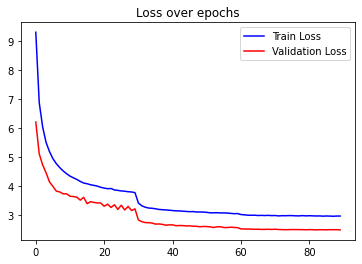

In [13]:
#Plot Loss over epochs
epcs = np.arange(90)

plt.title('Loss over epochs')
plt.plot(epcs,history['train_loss'],'-b',label='Train Loss')
plt.plot(epcs,history['validation_loss'],'-r',label='Validation Loss')
plt.legend(loc="upper right")